In [19]:
using HDF5, AeroAcoustics, PyPlot

In [20]:
csm_file = joinpath(dirname(@__DIR__),"test","data","test1_csm.h5")
csm_ref = h5open(csm_file, "r") do file
    read(file, "CsmData/csmReal")+im*read(file, "CsmData/csmImag")
end
fc = h5read(csm_file, "CsmData")["binCenterFrequenciesHz"]
micgeom = h5read(csm_file, "CsmData")["arrayGeom"]
z0 = h5readattr(csm_file, "CsmData")["z0"]

1.6

In [21]:
CSM = FreqArray(csm_ref,fc);

In [22]:
E = Environment(
    z0=z0,
    micgeom=micgeom,
    CSM=CSM,
    flim=(3000,4000),
    Nx = 21,
    Ny = 21,
    xlim=(-0.5,0.5),
    ylim=(-0.5,0.5)
    );

In [23]:
steeringvectors!(E)

In [24]:
b = beamforming(E);

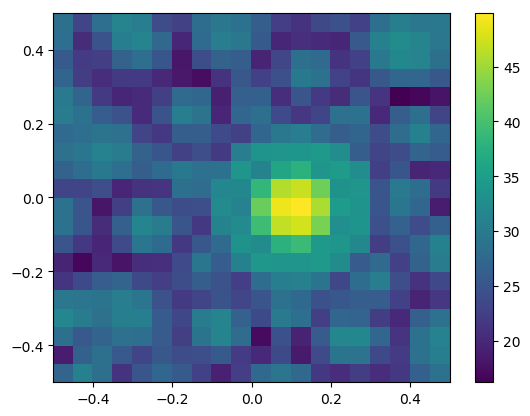

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb090e86dd8>

In [25]:
bdB = SPL.(reshape(b[:,1],E.Nx,E.Ny))
pcolormesh(E.rx,E.ry,bdB)
colorbar()